In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import keras
from tensorflow.keras.optimizers import Adam, SGD
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, 
                          Dropout, Rescaling, RandomFlip, RandomRotation, BatchNormalization)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

import cv2
import zipfile
import os
import glob
import shutil

## Unzip photos

In [2]:
train_dir = 'train'

with zipfile.ZipFile('/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip', 'r') as train_zip:
    train_zip.extractall('')

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
print(f"Train Data: {len(train_list)}")

base_dir = '/kaggle/working'
train_dir = os.path.join(base_dir, 'train')

Train Data: 25000


## Let’s visualize few data from training

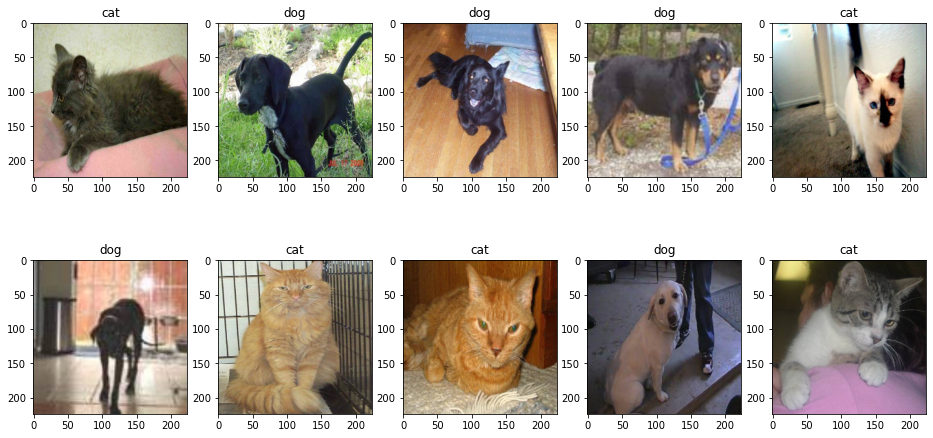

In [3]:
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_list[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' %path.split('/')[1].split('.')[0])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, (224,224))
    plt.imshow(img)

In [4]:
def get_label(filename):
  return filename.split('.jpg')[0].split('.')[0]

## Creating label and train directories

In [5]:
# Create labels directory
path = '/kaggle/working'
for image in os.listdir(train_dir):
  if not os.path.exists(os.path.join(path, get_label(image))):
    os.makedirs(os.path.join(path, get_label(image)))
  shutil.move(os.path.join(path+'/train', image),os.path.join(path, get_label(image), image))

In [6]:
print(len(os.listdir('/kaggle/working/dog')) + len(os.listdir('/kaggle/working/cat')))
shutil.rmtree('/kaggle/working/train/')
os.makedirs('/kaggle/working/images')
shutil.move('/kaggle/working/cat', '/kaggle/working/images/')
shutil.move('/kaggle/working/dog', '/kaggle/working/images/')
print(len(os.listdir('/kaggle/working/images/dog')) + len(os.listdir('/kaggle/working/images/cat')))

25000
25000


## Data preprocesing

In [7]:
img_height,img_width = 224, 224
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/kaggle/working/images/',
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True,
  label_mode='binary')
     
    
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/kaggle/working/images/',
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True,
  label_mode='binary')

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2023-02-07 12:21:50.699699: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 12:21:50.811622: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 12:21:50.812440: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 12:21:50.816276: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [8]:
train_ds

<BatchDataset shapes: ((None, 224, 224, 3), (None, 1)), types: (tf.float32, tf.float32)>

In [9]:
train_ds.class_names

['cat', 'dog']

In [10]:
rescale = Sequential([
  Rescaling(1./255)
])

In [11]:
data_augmentation = Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2),
])

## Plt some images after transform

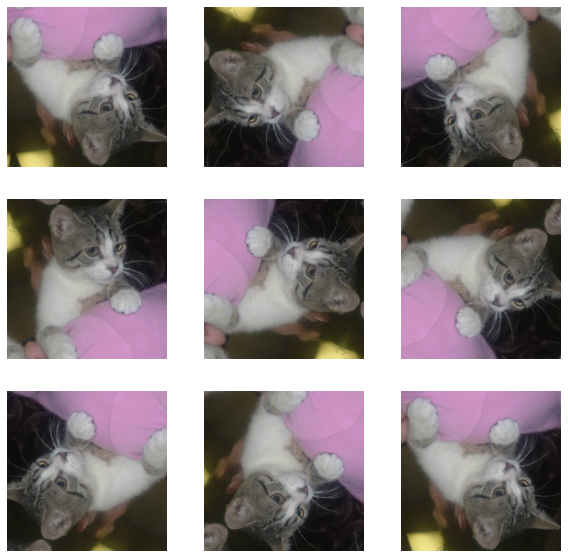

In [12]:
image = tf.expand_dims(img, 0)
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

## Resnet50 - base model for transfer learning

In [13]:
base_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',
                   weights='imagenet', classes=2)
for layer in base_model.layers:
        layer.trainable=False

94781440/94765736 [==============================] - 0s 0us/step


In [14]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## Add 2 dense layers for correct classification

In [15]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l1(1e-4)))

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 24,113,537
Trainable params: 525,313
Non-trainable params: 23,588,224
_________________________________________________________________


In [17]:
early_stop = EarlyStopping(monitor="val_loss",min_delta=0, patience=5,
                           verbose=0, mode="min", baseline=None, restore_best_weights=True)
check = ModelCheckpoint(filepath='convnet.keras', save_best_only=True, monitor='val_loss')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [18]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=SGD(learning_rate = 0.001, momentum = 0.1, decay = 0.0),
              metrics=['accuracy'])

In [19]:
num_epoch = 10
model_log = model.fit(train_ds,
                      epochs=num_epoch,
                      verbose=1,
                      validation_data=val_ds,
                      callbacks = [early_stop, check, learning_rate_reduction])
model.save_weights('weights.h5')

Epoch 1/10


2023-02-07 12:22:00.517725: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-07 12:22:02.165096: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


625/625 [==============================] - 61s 81ms/step - loss: 0.0036 - accuracy: 0.9396 - val_loss: 0.0063 - val_accuracy: 0.9698


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
625/625 [==============================] - 50s 80ms/step - loss: 0.0102 - accuracy: 0.9632 - val_loss: 0.0146 - val_accuracy: 0.9754
Epoch 3/10
625/625 [==============================] - 50s 79ms/step - loss: 0.0204 - accuracy: 0.9606 - val_loss: 0.0269 - val_accuracy: 0.9678
Epoch 4/10
625/625 [==============================] - 51s 80ms/step - loss: 0.0355 - accuracy: 0.9441 - val_loss: 0.0454 - val_accuracy: 0.9520

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/10
625/625 [==============================] - 49s 78ms/step - loss: 0.0516 - accuracy: 0.9269 - val_loss: 0.0582 - val_accuracy: 0.9448
Epoch 6/10
625/625 [==============================] - 49s 78ms/step - loss: 0.0660 - accuracy: 0.9109 - val_loss: 0.0744 - val_accuracy: 0.9360


## Create test directory

In [20]:
test_dir = 'test'
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip', 'r') as test_zip:
    test_zip.extractall('test')

test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
test_dir = os.path.join(base_dir, 'test')

## Create image generator for test data

In [21]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_data = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
    directory = '/kaggle/working/test/',
    target_size = (img_height,img_width),
    batch_size = 32,
    class_mode = None,
    shuffle = False,
    seed = 42
)

Found 12500 images belonging to 1 classes.


In [22]:
test_data.reset()

pred = model.predict(test_data, steps = len(test_data), verbose = 1)

391/391 [==============================] - 49s 123ms/step


## Plt result

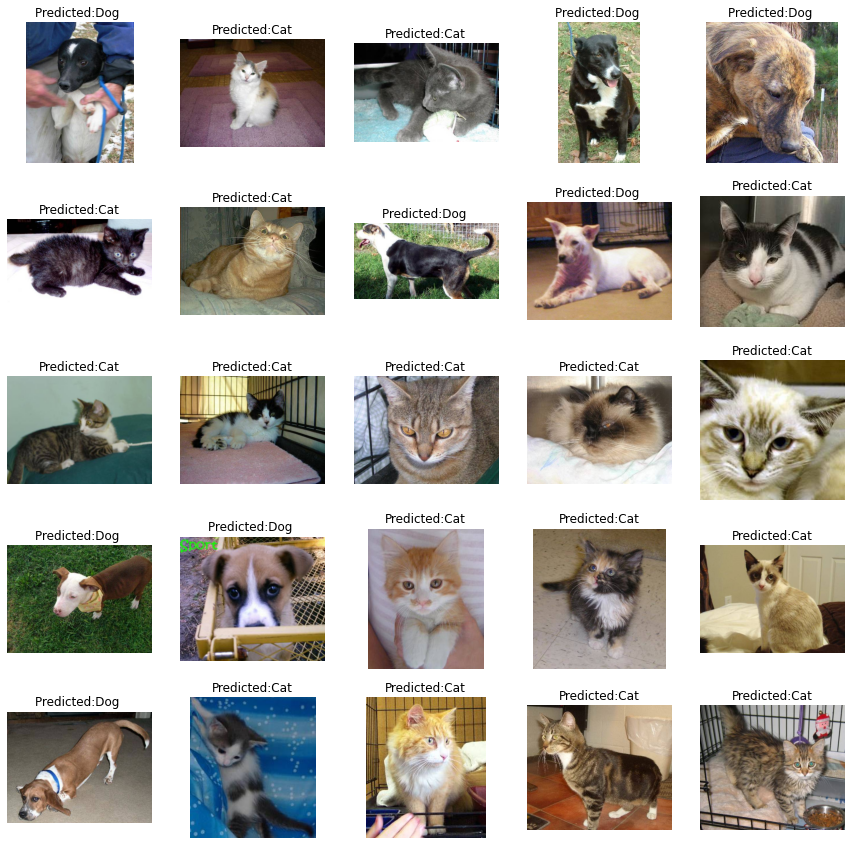

In [23]:
f, ax = plt.subplots(5, 5, figsize = (15, 15))

for i in range(0,25):
    imgBGR = cv2.imread('/kaggle/working/test/' + test_data.filenames[i])
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    
    # a if condition else b
    predicted_class = "Dog " if pred[i] > 0.5 else "Cat"

    ax[i//5, i%5].imshow(imgRGB)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))    

plt.show()

In [24]:
pred.clip(min=0.05, max=0.95)

array([[0.95],
       [0.05],
       [0.05],
       ...,
       [0.95],
       [0.05],
       [0.05]], dtype=float32)

In [25]:
sub = pd.read_csv('/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv')
sub.label = pred.clip(min=0.05, max=0.95)
sub

,id,label
0,1,0.95
1,2,0.05
2,3,0.05
3,4,0.95
4,5,0.95
...,...,...
12495,12496,0.05
12496,12497,0.95
12497,12498,0.95
12498,12499,0.05


In [26]:
sub.to_csv('submission.csv', index = False)